In [39]:
import json
import requests
import time
from datetime import datetime as dt
from datetime import timedelta
import talib as ta
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ccxt
from tqdm import tqdm
import vectorbt as vbt
import plotly.graph_objects as go

%matplotlib inline

print(ccxt.__version__)

ftx = ccxt.ftx({'enableRateLimit':True})
bn = ccxt.binance({'enableRateLimit':True})
zm = ccxt.zipmex({'enableRateLimit':True})
bf= ccxt.bitfinex({'enableRateLimit':True})
API_HOST = 'https://api.bitkub.com'


1.64.7


In [40]:
# !jupyter labextension list
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget


In [41]:
## CCXT Function 
def get_data(ex,symbols,**kwarg):
    # 
    
    df= pd.DataFrame(ex.fetch_ohlcv(symbols,**kwarg ),columns=['date','open','high','low','close','volume'])
    df['date']=df['date'].apply(ex.iso8601)
    df['date']=pd.to_datetime(df['date'])
    
    
    #   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
    #   df['date']=pd.to_datetime(df['date'])
    #   df.dropna(inplace=True)

    df.set_index('date',inplace=True)
    return df



def cal_spreard_ccxt(exchange,name_list):

    ''' exchange =ccxt.ExchangeClass
        name_sym ['list'] = symbol name'''
    data = []
    ex_name = exchange.name 
    for name_sym in name_list:
        if ex_name == 'Zipmex':
            
            symbols = name_sym+'/THB'
            
        elif  ex_name == 'Binance' :
            symbols = name_sym+'/USDT'
                    
        elif  ex_name == 'FTX' :
            symbols = name_sym+'/USD'

        else:
            symbols = name_sym+'/USD'
        res= exchange.fetch_ticker(symbols)
        last = res['last']
        ask = res['ask']
        bid = res['bid']
        volume= res['quoteVolume']
        spread=  ((ask-bid) / ask)*100
        if last >=1 :
            dict_a = {'exchange':ex_name,'symbol':symbols,'name':name_sym,'last':last,'volume':volume,'bid':bid,'ask':ask,'spread':spread}
            data.append(dict_a)
    return data
cal_spreard_ccxt(ftx,['SOL'])

[{'exchange': 'FTX',
  'symbol': 'SOL/USD',
  'name': 'SOL',
  'last': 99.5375,
  'volume': 115668646.858825,
  'bid': 99.5025,
  'ask': 99.53,
  'spread': 0.027629860343618418}]

In [292]:
def get_thb():
    from tvDatafeed import TvDatafeed, Interval
    tv = TvDatafeed()
    symbols ='USDTHB'
    exchanges= 'GLOBALPRIME'
    timeframe = Interval.in_daily
    limit_bar =1
    df = tv.get_hist(symbol=symbols,exchange='OANDA',interval=timeframe,n_bars=limit_bar)
    return df['close'].values[0]


def get_price_bk(sym):
    try:
        req = '/api/market/ticker'
        url = API_HOST+req
        syms= 'THB_'+ sym
        param ={'sym':syms}
        res = requests.get(url,params=param).json()
        last = res[syms]['last']
        return last 
    except Exception as e:
        print(str(e), syms)
        
def bk_ticker(symbols='all'): 
    ''' symbols : List'''

    bit_kub_list = []
    all_res = {}

    req = '/api/market/ticker'
    url = API_HOST+req
    if symbols =='all':
        param ={'query':'all'}
        all_res = requests.get(url,params=param).json()
        return all_res

    else :
            for sym in symbols:
                    try:
                        param ={'sym':sym}
                        # print(sym)
                        res = requests.get(url,params=param).json()
                        # print(sym,res)
                        # print(res)
                        all_res.update(res)
                    except  Exception as e:
                        print(str(e))
                        all_res[sym] ={'last':None}  
    return all_res
def cal_spread_bk(all_res,convert_usd=False):
    data = []
    if not convert_usd:
        for i in all_res:
            name= i.split('_')[1]
            last = float(all_res[i]['last'])
            volume = float(all_res[i]['quoteVolume'])
            bid = float(all_res[i]['highestBid'])
            ask = float(all_res[i]['lowestAsk'])
            spread = ((ask -bid) /ask)*100

            if last > 1.0:
                dict_a = {'exchange':'bitkub','symbol':i,'name':name,'last':last,'volume':volume,'bid':bid,'ask':ask,'spread':spread}
                data.append(dict_a)
    else:
        usd_thb = get_thb()
        for i in all_res:
            name= i.split('_')[1]
            last = float(all_res[i]['last']) /usd_thb
            volume = float(all_res[i]['quoteVolume']) /usd_thb
            bid = float(all_res[i]['highestBid'])/usd_thb
            ask = float(all_res[i]['lowestAsk'])/usd_thb
            spread = ((ask -bid) /ask)*100

            dict_a = {'exchange':'bitkub','symbol':i,'name':name,'last':last,'volume':volume,'bid':bid,'ask':ask,'spread':spread}
            data.append(dict_a)
    return data



def compare_spread(ex,spread_list):      
    compare_spread = []
    last_price = None
    
    for i in tqdm(spread_list):
        name = i['name']
        if ex.name=='FTX':
            symbols = i['name']+'/USD'
        elif ex.name =='Zipmex':
            symbols= i['name']+'/THB'

        else:
#             print(ex.name)
            symbols = i['name']+'/USDT'

        print(symbols)
        try:
            res = ex.fetch_ticker(symbols)
            last_price = res['last']
            bid =res['bid']
            ask = res['ask']
            spread = ((ask -bid) /ask)*100

        except Exception as e:
            last_price= None 
            spread =None 
            print(str(e))
            
            
        if last_price != None:   
            dict_b= {'exchange':ex.name,'symbol':symbols,'name':name,'last':last_price,'bid':bid,'ask':ask,'spread':spread}
            compare_spread.append(dict_b)
            
    return compare_spread






In [303]:
# cal_spread_bk(['THB_FTT'])
symbols=['THB_BTC','THB_ETH','THB_BNB','THB_XRP','THB_KUB','THB_FTT','THB_SOL',\
        'THB_LTC','THB_SAND','THB_MANA','THB_DOGE','THB_USDC','THB_USDT']

res= bk_ticker(symbols)
spread_bk =  cal_spread_bk(res,True)
bk_df = pd.DataFrame(spread_bk)


In [296]:
bk_df

,exchange,symbol,name,last,volume,bid,ask,spread
0,bitkub,THB_BTC,BTC,42962.228715,1.601923e+07,42962.675888,42990.623062,0.065008
1,bitkub,THB_ETH,ETH,3031.258943,1.171353e+07,3028.857620,3031.271762,0.079641
2,bitkub,THB_BNB,BNB,407.861018,8.268733e+05,407.859528,409.229370,0.334737
3,bitkub,THB_XRP,XRP,0.835321,1.920145e+06,0.835023,0.835321,0.035689
4,bitkub,THB_KUB,KUB,7.830312,5.386601e+06,7.830014,7.837169,0.091293
5,bitkub,THB_FTT,FTT,46.805688,1.394554e+05,46.807477,46.819103,0.024833
6,bitkub,THB_SOL,SOL,99.365013,1.500198e+06,99.365013,99.424338,0.059669
7,bitkub,THB_LTC,LTC,121.385345,1.923067e+05,121.385345,121.613403,0.187528
8,bitkub,THB_SAND,SAND,3.330551,4.551562e+06,3.330551,3.333234,0.080494
9,bitkub,THB_MANA,MANA,2.602850,2.130332e+06,2.602850,2.604639,0.068673


# Compare By bitkub

In [381]:
# Load ticker on bitkub and calculation spread
symbols=['THB_BTC','THB_ETH','THB_BNB','THB_XRP','THB_KUB','THB_FTT','THB_SOL',\
        'THB_LTC','THB_SAND','THB_MANA','THB_DOGE','THB_USDC','THB_USDT']

res= bk_ticker(symbols)
spread_bk =  cal_spread_bk(res)
bk_df = pd.DataFrame(spread_bk)
# convert to usd 
# bk_df['last'] = bk_df['last'] / usd_thb
# bk_df['bid'] = bk_df['bid'] / usd_thb
# bk_df['ask'] = bk_df['ask'] / usd_thb

bk_df.sort_values('volume',ascending=False)
# bk_df.sort_values('spread',ascending=False)

,exchange,symbol,name,last,volume,bid,ask,spread
12,bitkub,THB_USDT,USDT,33.61,7.332432e+08,3.361000e+01,3.362000e+01,0.029744
0,bitkub,THB_BTC,BTC,1474999.78,6.137417e+08,1.474400e+06,1.475000e+06,0.040660
1,bitkub,THB_ETH,ETH,104087.00,3.901545e+08,1.040870e+05,1.041570e+05,0.067206
10,bitkub,THB_DOGE,DOGE,4.54,1.784193e+08,4.540600e+00,4.547400e+00,0.149536
8,bitkub,THB_SAND,SAND,113.85,1.436577e+08,1.136100e+02,1.138500e+02,0.210804
4,bitkub,THB_KUB,KUB,260.52,1.406999e+08,2.605200e+02,2.610000e+02,0.183908
3,bitkub,THB_XRP,XRP,28.27,6.431046e+07,2.827000e+01,2.831000e+01,0.141293
9,bitkub,THB_MANA,MANA,88.43,5.746843e+07,8.842000e+01,8.845000e+01,0.033917
11,bitkub,THB_USDC,USDC,33.59,4.232790e+07,3.351000e+01,3.358000e+01,0.208457
6,bitkub,THB_SOL,SOL,3413.38,4.108476e+07,3.403580e+03,3.413180e+03,0.281263


In [95]:
speard_ftx = compare_spread(ftx,spread_bk)
ftx_df = pd.DataFrame(speard_ftx)
ftx_df

NameError: name 'spread_bk' is not defined

In [99]:
spread_bn = compare_spread(bn,spread_bk)
# spread_bn = compare_spread(binance,speard_ftx)
bn_df = pd.DataFrame(spread_bn)
bn_df

 31%|█████████████████████████████████▏                                                                          | 4/13 [00:02<00:05,  1.54it/s]

binance does not have market symbol KUB/USDT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:05<00:00,  2.18it/s]

binance does not have market symbol USDT/USDT


,exchange,symbol,name,last,bid,ask,spread
0,Binance,BTC/USDT,BTC,42926.0000,42926.0000,42926.0100,0.000023
1,Binance,ETH/USDT,ETH,3045.5500,3045.5400,3045.0600,-0.015763
2,Binance,BNB/USDT,BNB,409.4000,409.3000,409.4000,0.024426
3,Binance,XRP/USDT,XRP,0.8338,0.8337,0.8338,0.011993
4,Binance,FTT/USDT,FTT,46.9500,46.9400,46.9500,0.021299
5,Binance,SOL/USDT,SOL,100.0700,100.0700,100.0800,0.009992
6,Binance,LTC/USDT,LTC,121.8000,121.8000,121.9000,0.082034
7,Binance,SAND/USDT,SAND,3.3856,3.3856,3.3856,0.000000
8,Binance,MANA/USDT,MANA,2.6163,2.6163,2.6164,0.003822
9,Binance,DOGE/USDT,DOGE,0.1382,0.1381,0.1382,0.072359


In [384]:
spread_zm = compare_spread(zm,spread_bk)
# spread_zm = compare_spread(zm,speard_ftx)
zm_df = pd.DataFrame(spread_zm)
# convert to usd 
zm_df['last'] = zm_df['last'] / usd_thb
zm_df['bid'] = zm_df['bid'] / usd_thb
zm_df['ask'] = zm_df['ask'] / usd_thb

zm_df

 31%|█████████████████████████████████▏                                                                          | 4/13 [00:03<00:06,  1.30it/s]

zipmex does not have market symbol KUB/THB


 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 10/13 [00:08<00:02,  1.08it/s]

zipmex does not have market symbol DOGE/THB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:10<00:00,  1.29it/s]


,exchange,symbol,name,last,bid,ask,spread
0,Zipmex,BTC/THB,BTC,1.468236e+06,1.465939e+06,1.468293e+06,0.160324
1,Zipmex,ETH/THB,ETH,1.033896e+05,1.033896e+05,1.036251e+05,0.227184
2,Zipmex,BNB/THB,BNB,1.383010e+04,1.383000e+04,1.386800e+04,0.274012
3,Zipmex,XRP/THB,XRP,2.818779e+01,2.813127e+01,2.820955e+01,0.277495
4,Zipmex,FTT/THB,FTT,1.600730e+03,1.601370e+03,1.605680e+03,0.268422
5,Zipmex,SOL/THB,SOL,3.380000e+03,3.379720e+03,3.391800e+03,0.356153
6,Zipmex,LTC/THB,LTC,4.177428e+03,4.165711e+03,4.177383e+03,0.279409
7,Zipmex,SAND/THB,SAND,1.129916e+02,1.128893e+02,1.133985e+02,0.449001
8,Zipmex,MANA/THB,MANA,8.799380e+01,8.778040e+01,8.824170e+01,0.522769
9,Zipmex,USDC/THB,USDC,3.344009e+01,3.341048e+01,3.344010e+01,0.088576


In [101]:

spread_bf = compare_spread(bf,spread_bk)
bf_df = pd.DataFrame(spread_bf)
bf_df

 15%|████████████████▌                                                                                           | 2/13 [00:07<00:38,  3.50s/it]

bitfinex does not have market symbol BNB/USDT


 31%|█████████████████████████████████▏                                                                          | 4/13 [00:12<00:28,  3.12s/it]

bitfinex does not have market symbol KUB/USDT


 62%|██████████████████████████████████████████████████████████████████▍                                         | 8/13 [00:25<00:18,  3.69s/it]

bitfinex does not have market symbol SAND/USDT
bitfinex does not have market symbol MANA/USDT


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:34<00:00,  2.66s/it]

bitfinex does not have market symbol USDT/USDT


,exchange,symbol,name,last,bid,ask,spread
0,Bitfinex,BTC/USDT,BTC,42935.00000,42942.00000,42945.00000,0.006986
1,Bitfinex,ETH/USDT,ETH,3045.90000,3044.70000,3046.10000,0.045960
2,Bitfinex,XRP/USDT,XRP,0.83450,0.83373,0.83445,0.086284
3,Bitfinex,FTT/USDT,FTT,47.14100,46.88200,46.99500,0.240451
4,Bitfinex,SOL/USDT,SOL,100.17000,100.05000,100.16000,0.109824
5,Bitfinex,LTC/USDT,LTC,122.08000,121.90000,122.07000,0.139264
6,Bitfinex,DOGE/USDT,DOGE,0.13826,0.13814,0.13826,0.086793
7,Bitfinex,USDC/USDT,USDC,0.99969,0.99937,0.99970,0.033010


### Combine ALL DATA

In [76]:
# df2 = pd.concat([zm_df,bk_df,ftx_df,bn_df],join='inner')
df2 = pd.concat([zm_df,bf_df,ftx_df,bn_df],join='inner')
df2

,exchange,symbol,name,last,bid,ask,spread
0,Zipmex,BTC/THB,BTC,42897.375380,42831.307843,42897.375380,0.154013
1,Zipmex,ETH/THB,ETH,3044.575368,3041.814960,3046.748854,0.161940
2,Zipmex,BNB/THB,BNB,409.302603,408.453934,409.359181,0.221138
3,Zipmex,XRP/THB,XRP,0.831811,0.832229,0.833806,0.189030
4,Zipmex,FTT/THB,FTT,46.760765,46.804240,46.935858,0.280421
5,Zipmex,SOL/THB,SOL,99.905009,99.895182,100.265023,0.368863
6,Zipmex,LTC/THB,LTC,121.966887,121.671014,121.884611,0.175245
7,Zipmex,SAND/THB,SAND,3.386571,3.376809,3.388423,0.342763
8,Zipmex,MANA/THB,MANA,2.605563,2.605563,2.618349,0.488346
9,Zipmex,USDC/THB,USDC,0.997558,0.996870,0.997558,0.068985


### Groupby 

symbol          last           bid           ask    spread
exchange name                                                               
Binance  BNB    BNB/USDT    409.700000    409.700000    409.800000  0.024402
         BTC    BTC/USDT  42944.010000  42943.890000  42943.900000  0.000023
         DOGE  DOGE/USDT      0.138100      0.138000      0.138100  0.072411
         ETH    ETH/USDT   3051.270000   3051.270000   3051.280000  0.000328
         FTT    FTT/USDT     46.940000     46.940000     46.950000  0.021299
         LTC    LTC/USDT    122.000000    122.000000    122.100000  0.081900
         MANA  MANA/USDT      2.617300      2.617000      2.617200  0.007642
         SAND  SAND/USDT      3.390500      3.389300      3.389400  0.002950
         SOL    SOL/USDT    100.340000    100.340000    100.350000  0.009965
         USDC  USDC/USDT      0.999600      0.999500      0.999600  0.010004
         XRP    XRP/USDT      0.834700      0.834700      0.834800  0.011979
Bitfinex BTC    BTC/USDT  42969.000000  42961.000000  42973.000000  0.027925
         DOGE  DOGE/USDT      0.138280      0.138200      0.138300  0.072307
         ETH    ETH/USDT   3051.800000   3050.600000   3051.800000  0.039321
         FTT    FTT/USDT     47.141000     46.916000     47.007000  0.193588
         LTC    LTC/USDT    122.190000    122.060000    122.190000  0.106392
         SOL    SOL/USDT    100.350000    100.280000    100.380000  0.099621
         USDC  USDC/USDT      0.999690      0.999370      0.999700  0.033010
         XRP    XRP/USDT      0.834440      0.834580      0.835200  0.074234
FTX      BNB     BNB/USD    409.971000    410.000000    410.001000  0.000244
         BTC     BTC/USD  42966.000000  42960.000000  42961.000000  0.002328
         DOGE   DOGE/USD      0.138164      0.138150      0.138204  0.039073
         ETH     ETH/USD   3053.700000   3053.600000   3053.700000  0.003275
         FTT     FTT/USD     46.988000     46.989000     46.993000  0.008512
         LTC     LTC/USD    122.075000    122.055000    122.080000  0.020478
         MANA   MANA/USD      2.614400      2.615600      2.616600  0.038218
         SAND   SAND/USD      3.385400      3.385950      3.386950  0.029525
         SOL     SOL/USD    100.382500    100.367500    100.380000  0.012453
         USDT   USDT/USD      1.000400      1.000300      1.000400  0.009996
         XRP     XRP/USD      0.834775      0.834825      0.834900  0.008983
Zipmex   BNB     BNB/THB    409.302603    408.453934    409.359181  0.221138
         BTC     BTC/THB  42897.375380  42831.307843  42897.375380  0.154013
         ETH     ETH/THB   3044.575368   3041.814960   3046.748854  0.161940
         FTT     FTT/THB     46.760765     46.804240     46.935858  0.280421
         LTC     LTC/THB    121.966887    121.671014    121.884611  0.175245
         MANA   MANA/THB      2.605563      2.605563      2.618349  0.488346
         SAND   SAND/THB      3.386571      3.376809      3.388423  0.342763
         SOL     SOL/THB     99.905009     99.895182    100.265023  0.368863
         USDC   USDC/THB      0.997558      0.996870      0.997558  0.068985
         USDT   USDT/THB      0.998449      0.996989      0.998452  0.146436
         XRP     XRP/THB      0.831811      0.832229      0.833806  0.189030

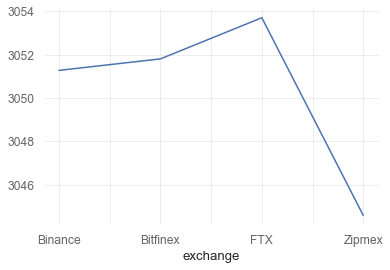

In [77]:
df3 = df2.groupby(['exchange','name']).agg('last')
# print(df3.index)
df3.unstack()['last']['ETH'].plot()
df3

# Check Most Discount On Multi Exchange

In [43]:

## Compare FTX & Binance By symbol
sym_name = 'ETH'
ftx_bnb = df3.iloc[(df3.index.get_level_values('exchange') == 'FTX') &( df3.index.get_level_values('name') == sym_name)]\
['last'].values[0]
binance_bnb = df3.iloc[(df3.index.get_level_values('exchange') == 'Binance') &( df3.index.get_level_values('name') == sym_name)]\
['last'].values[0]



if binance_bnb < ftx_bnb:
    print(f'{sym_name} Discount  On Binance')
    print(f'Binance  : {binance_bnb},FTX :{ftx_bnb}'+'' ,(binance_bnb/ ftx_bnb-1)*100,'%')
else:
    print(f'{sym_name} Discount  On FTX')

    print(f'Binance  : {binance_bnb},FTX :{ftx_bnb}'+'',(binance_bnb/ ftx_bnb-1)*100,'%')


ETH Discount  On Binance
Binance  : 3052.0,FTX :3053.2 -0.03930302633302629 %


In [42]:
## Filter Exchange & Symbol
df3[(df3.index.get_level_values('exchange') == 'Zipmex'  )&\
   (df3.index.get_level_values('name') == 'BNB')] 

,,symbol,last,bid,ask,spread
exchange,name,,,,,
Zipmex,BNB,BNB/THB,409.052469,409.049491,410.002382,0.232411


In [104]:
pd.concat([ftx_df,zm_df,bn_df,bf_df],join='inner')

,exchange,name,last,bid,ask,spread
0,FTX,SOL,99.265000,99.250000,99.265000,0.015111
1,FTX,ETH,3039.300000,3039.200000,3039.300000,0.003290
2,FTX,BNB,409.200000,409.173000,409.174000,0.000244
3,FTX,FTT,46.933000,46.926000,46.928000,0.004262
0,Zipmex,SOL,99.517110,98.962680,99.297723,0.337412
1,Zipmex,ETH,3035.572910,3032.054072,3035.372600,0.109329
2,Zipmex,BNB,409.994635,408.396924,409.121259,0.177047
3,Zipmex,FTT,46.810242,46.796232,46.925301,0.275052
0,Binance,SOL,99.340000,99.340000,99.350000,0.010065
1,Binance,ETH,3038.260000,3038.260000,3038.270000,0.000329


In [115]:
view_df =pd.concat([ftx_df_sf,bn_df_sf,zm_df_sf],axis=1)
view_df

,exchange_ftx,last_ftx,bid_ftx,ask_ftx,exchange_bn,last_bn,bid_bn,ask_bn,exchange_zm,last_zm,bid_zm,ask_zm
0,FTX,42943.000000,42944.000000,42945.000000,Binance,42926.0000,42926.0000,42926.0100,Zipmex,42833.979215,42833.979215,42882.676732
1,FTX,3047.400000,3047.300000,3047.400000,Binance,3045.5500,3045.5400,3045.0600,Zipmex,3043.981002,3039.486034,3042.687749
2,FTX,409.728000,409.727000,409.728000,Binance,409.4000,409.3000,409.4000,Zipmex,408.355667,408.254422,409.106069
3,FTX,0.834425,0.834300,0.834325,Binance,0.8338,0.8337,0.8338,Zipmex,0.831689,0.831409,0.832984
4,FTX,46.979000,46.973000,46.974000,Binance,46.9500,46.9400,46.9500,Zipmex,46.793818,46.790543,46.920672
5,FTX,100.127500,100.122500,100.140000,Binance,100.0700,100.0700,100.0800,Zipmex,99.865702,99.725746,100.075934
6,FTX,121.915000,121.905000,121.925000,Binance,121.8000,121.8000,121.9000,Zipmex,121.493092,121.493062,121.752814
7,FTX,3.391000,3.388200,3.390250,Binance,3.3856,3.3856,3.3856,Zipmex,3.386130,3.376809,3.385110
8,FTX,2.620400,2.617900,2.619700,Binance,2.6163,2.6163,2.6164,Zipmex,2.605565,2.605563,2.618224
9,FTX,0.138289,0.138223,0.138257,Binance,0.1382,0.1381,0.1382,Zipmex,0.997558,0.996870,0.997558


# Compare Exchange On CCXT libs

In [366]:

start_time = time.time()
speard_ftx =cal_spreard_ccxt(ftx,['SOL','ETH','BNB','FTT','USDT','XRP','LUNA','SRM'])
ftx_df = pd.DataFrame(speard_ftx)
ftx_df = ftx_df[['exchange','name','last','bid','ask','spread']]

spread_zm = compare_spread(zm,speard_ftx)
# spread_zm = compare_spread(zm,speard_ftx)
zm_df = pd.DataFrame(spread_zm)[['exchange','name','last','bid','ask','spread']]
# convert to usd 
zm_df['last'] = zm_df['last'] / usd_thb
zm_df['bid'] = zm_df['bid'] / usd_thb
zm_df['ask'] = zm_df['ask'] / usd_thb



spread_bn = compare_spread(bn,speard_ftx)
bn_df = pd.DataFrame(spread_bn)[['exchange','name','last','bid','ask','spread']]


spread_bf = compare_spread(bf,speard_ftx)
bf_df = pd.DataFrame(spread_bf)[['exchange','name','last','bid','ask','spread']]
print(f'Diff Time' ,time.time() -start_time ,' Seconds')

 57%|██████████████████████████████████████████████████████████████▎                                              | 4/7 [00:02<00:01,  1.86it/s]

binance does not have market symbol USDT/USDT


 29%|███████████████████████████████▏                                                                             | 2/7 [00:07<00:17,  3.47s/it]

bitfinex does not have market symbol BNB/USDT


 57%|██████████████████████████████████████████████████████████████▎                                              | 4/7 [00:12<00:09,  3.11s/it]

bitfinex does not have market symbol USDT/USDT


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:21<00:00,  3.00s/it]

Diff Time 46.28586006164551  Seconds


In [357]:
ftx_df1 = ftx_df[['exchange','name','bid','ask']]
zm_df1 = zm_df[['exchange','name','bid','ask']]
bn_df1 = bn_df[['exchange','name','bid','ask']]
bf_df1 = bf_df[['exchange','name','bid','ask']]


In [358]:

bf_df1.columns = [str(col) + '_bf'  if col != 'name' else str(col) for col in bf_df1.columns]
zm_df1.columns = [str(col) + '_zm'  if col != 'name' else str(col) for col in zm_df1.columns]
ftx_df1.columns = [str(col) + '_ftx'  if col != 'name' else str(col) for col in ftx_df1.columns]
bn_df1.columns = [str(col) + '_bn'  if col != 'name' else str(col) for col in bn_df1.columns]


v_df = pd.merge(ftx_df1,bn_df1,on='name',how='left')
v_df =v_df.merge(zm_df1,on='name',how='left')
v_df =v_df.merge(bf_df1,on='name',how='left')
v_df

,exchange_ftx,name,bid_ftx,ask_ftx,exchange_bn,bid_bn,ask_bn,exchange_zm,bid_zm,ask_zm,exchange_bf,bid_bf,ask_bf
0,FTX,SOL,100.2075,100.2100,Binance,100.24,100.25,Zipmex,100.025036,100.395809,Bitfinex,100.220,100.280
1,FTX,ETH,3026.8000,3026.9000,Binance,3026.87,3026.88,Zipmex,3026.673323,3031.770264,Bitfinex,3025.800,3027.200
2,FTX,BNB,407.6320,407.7360,Binance,407.60,407.70,Zipmex,407.251539,408.428833,NaN,NaN,NaN
3,FTX,FTT,46.7870,46.7910,Binance,46.76,46.77,Zipmex,46.752306,46.877785,Bitfinex,46.681,46.808
4,FTX,USDT,1.0003,1.0004,NaN,NaN,NaN,Zipmex,0.999908,1.000253,NaN,NaN,NaN


# add bitkub

In [359]:
# cal_spread_bk(['THB_FTT'])
# symbols=['THB_BTC','THB_ETH','THB_BNB','THB_XRP','THB_KUB','THB_FTT','THB_SOL',\]
symbols = ['THB_'+str(i) for i in v_df.name]
res= bk_ticker(symbols)
spread_bk2 =  cal_spread_bk(res,False)

spread_bk =  cal_spread_bk(res,True)
bk_df = pd.DataFrame(spread_bk)


In [360]:
bk_df1 = bk_df[['exchange','name','bid','ask']]
bk_df1.columns = [str(col) + '_bk'  if col != 'name' else str(col) for col in bk_df1.columns]
v_df =v_df.merge(bk_df1,on='name',how='left')
v_df

,exchange_ftx,name,bid_ftx,ask_ftx,exchange_bn,bid_bn,ask_bn,exchange_zm,bid_zm,ask_zm,exchange_bf,bid_bf,ask_bf,exchange_bk,bid_bk,ask_bk
0,FTX,SOL,100.2075,100.2100,Binance,100.24,100.25,Zipmex,100.025036,100.395809,Bitfinex,100.220,100.280,bitkub,100.646277,100.764026
1,FTX,ETH,3026.8000,3026.9000,Binance,3026.87,3026.88,Zipmex,3026.673323,3031.770264,Bitfinex,3025.800,3027.200,bitkub,3036.278245,3040.599475
2,FTX,BNB,407.6320,407.7360,Binance,407.60,407.70,Zipmex,407.251539,408.428833,NaN,NaN,NaN,bitkub,408.719370,409.289036
3,FTX,FTT,46.7870,46.7910,Binance,46.76,46.77,Zipmex,46.752306,46.877785,Bitfinex,46.681,46.808,bitkub,46.901270,46.917665
4,FTX,USDT,1.0003,1.0004,NaN,NaN,NaN,Zipmex,0.999908,1.000253,NaN,NaN,NaN,bitkub,1.003995,1.004591


In [364]:
v_df

,exchange_ftx,name,bid_ftx,ask_ftx,exchange_bn,bid_bn,ask_bn,exchange_zm,bid_zm,ask_zm,exchange_bf,bid_bf,ask_bf,exchange_bk,bid_bk,ask_bk
0,FTX,SOL,100.2075,100.2100,Binance,100.24,100.25,Zipmex,100.025036,100.395809,Bitfinex,100.220,100.280,bitkub,100.646277,100.764026
1,FTX,ETH,3026.8000,3026.9000,Binance,3026.87,3026.88,Zipmex,3026.673323,3031.770264,Bitfinex,3025.800,3027.200,bitkub,3036.278245,3040.599475
2,FTX,BNB,407.6320,407.7360,Binance,407.60,407.70,Zipmex,407.251539,408.428833,NaN,NaN,NaN,bitkub,408.719370,409.289036
3,FTX,FTT,46.7870,46.7910,Binance,46.76,46.77,Zipmex,46.752306,46.877785,Bitfinex,46.681,46.808,bitkub,46.901270,46.917665
4,FTX,USDT,1.0003,1.0004,NaN,NaN,NaN,Zipmex,0.999908,1.000253,NaN,NaN,NaN,bitkub,1.003995,1.004591


In [361]:
v_df2= v_df[['exchange_ftx','name','bid_ftx','ask_ftx','exchange_bk','bid_bk','ask_bk']]
v_df2['diff_ftx_bk'] =(v_df2['bid_ftx'] / v_df2['bid_bk'] -1) *100
v_df2

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,exchange_ftx,name,bid_ftx,ask_ftx,exchange_bk,bid_bk,ask_bk,diff_ftx_bk
0,FTX,SOL,100.2075,100.2100,bitkub,100.646277,100.764026,-0.435959
1,FTX,ETH,3026.8000,3026.9000,bitkub,3036.278245,3040.599475,-0.312167
2,FTX,BNB,407.6320,407.7360,bitkub,408.719370,409.289036,-0.266043
3,FTX,FTT,46.7870,46.7910,bitkub,46.901270,46.917665,-0.243639
4,FTX,USDT,1.0003,1.0004,bitkub,1.003995,1.004591,-0.367982


In [365]:
v_df3= v_df[['exchange_ftx','name','bid_ftx','ask_ftx','exchange_zm','bid_zm','ask_zm']]
v_df3['diff_ftx_bk'] =(v_df['bid_ftx'] / v_df['bid_zm'] -1) *100
v_df3

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,exchange_ftx,name,bid_ftx,ask_ftx,exchange_zm,bid_zm,ask_zm,diff_ftx_bk
0,FTX,SOL,100.2075,100.2100,Zipmex,100.025036,100.395809,0.182418
1,FTX,ETH,3026.8000,3026.9000,Zipmex,3026.673323,3031.770264,0.004185
2,FTX,BNB,407.6320,407.7360,Zipmex,407.251539,408.428833,0.093422
3,FTX,FTT,46.7870,46.7910,Zipmex,46.752306,46.877785,0.074208
4,FTX,USDT,1.0003,1.0004,Zipmex,0.999908,1.000253,0.039243


In [ ]:
# คำนวน DIFF , Volume รวม bid ,ask  Exchange ที่จะขาย , price volatility loss/gain ,speed transcation 

In [362]:

# view_df = ftx_df.merge(zm_df,on='name',suffixes=['_ftx','_zm'])
view_df = pd.concat([ftx_df,bn_df,bf_df,zm_df],join='inner')#,keys=['_ftx','_bn','_bf','_zm'])
view_df.groupby(['exchange','name']).agg('last')


last          bid          ask    spread
exchange name                                                 
Binance  BNB    407.700000   407.600000   407.700000  0.024528
         ETH   3026.870000  3026.870000  3026.880000  0.000330
         FTT     46.770000    46.760000    46.770000  0.021381
         SOL    100.250000   100.240000   100.250000  0.009975
Bitfinex ETH   3025.600000  3025.800000  3027.200000  0.046247
         FTT     47.141000    46.681000    46.808000  0.271321
         SOL    100.170000   100.220000   100.280000  0.059832
FTX      BNB    407.642000   407.632000   407.736000  0.025507
         ETH   3026.900000  3026.800000  3026.900000  0.003304
         FTT     46.789000    46.787000    46.791000  0.008549
         SOL    100.207500   100.207500   100.210000  0.002495
         USDT     1.000400     1.000300     1.000400  0.009996
Zipmex   BNB    408.324516   407.251539   408.428833  0.288250
         ETH   3031.222747  3026.673323  3031.770264  0.168118
         FTT     46.908186    46.752306    46.877785  0.267672
         SOL     99.895683   100.025036   100.395809  0.369312
         USDT     1.000250     0.999908     1.000253  0.034565

# Test

In [246]:
# quick view
name_sym = 'SOL'
usd_thb = get_thb()
def fast_view(name_sym:str,debug=True):

        bk_sym = 'THB_'+name_sym
        p1=spread_symbol(ftx,name_sym+'/USDT')
        p2=spread_symbol(binance,name_sym+'/USDT')
        p3= spread_symbol(zm,name_sym+'/THB')
        p4 =  bk_ticker([bk_sym])
 
    # display(p3.iloc[[0]],p2.iloc[[0]],p1.iloc[[0]])


        zm_usd  =float(round((p3.iloc[[0]]['asks_price'].values[0] / usd_thb),5))
        bk_usd = float(round(p4[bk_sym]['last'] / usd_thb,5))
        bn_usd = p2.iloc[[0]]['asks_price'].values[0]
        ftx_usd = p1.iloc[[0]]['asks_price'].values[0]

        diff = (zm_usd/bn_usd)-1
        diff2 = (zm_usd/ftx_usd)-1
        diff3 = (ftx_usd/bn_usd)-1

        diff4 = (bk_usd/bn_usd)-1
        diff5 = (bk_usd/ftx_usd)-1
        diff6 = (bk_usd/zm_usd)-1

        if debug:
            print(f' Zipmex {zm_usd:.5f} Binance {bn_usd:.5f} {diff*100:.2f}%')
            print(f' Zipmex {zm_usd:.5f} FTX {ftx_usd:.5f}  {diff2*100:.2f}%')
            print(f' FTX {ftx_usd:.5f} Binance {bn_usd:.5f}  {diff3*100:.2f}%')
            print(f' BITKUB {bk_usd:.5f} Binance {bn_usd:.5f}  {diff4*100:.2f}%')
            print(f' BITKUB {bk_usd:.5f} FTX {ftx_usd:.5f}  {diff5*100:.2f}%')
            print(f' BITKUB {bk_usd:.5f} Zipmex {zm_usd:.5f}  {diff6*100:.2f}%')
        dict_data= {'symbol':name_sym,'zipmex':zm_usd,'binance':bn_usd,'ftx':ftx_usd,'bk_usd':bk_usd}
        return pd.DataFrame([dict_data])




In [253]:
# check_ticker(zm,'FTT')

In [254]:
ex_list = [zm,bn,ftx,bf]
sym_list = ['FTT','ETH','SOL','BNB','LUNA']



In [255]:
all_data= []
for ex in ex_list:
        for sym in sym_list :
            try:
                res =check_ticker(ex,sym)
                last_ask = res['ask']
                last_bid = res['bid']
            except Exception as e:
                print(str(e))
                res =None 
                last_ask = None
                last_bid =None
            dict_data = {'exchange':ex.name,'symbols':sym,'last_bid':last_bid,'last_ask':last_ask}
            all_data.append(dict_data)


bitfinex does not have market symbol BNB/USD


In [256]:
all_df =pd.DataFrame(all_data)
all_df_2 = all_df.groupby(['exchange','symbols']).agg('last')

In [257]:
all_df_2

last_bid     last_ask
exchange symbols                          
Binance  BNB       407.400000   407.500000
         ETH      3017.670000  3017.680000
         FTT        46.660000    46.670000
         LUNA       92.630000    92.640000
         SOL        99.230000    99.240000
Bitfinex BNB              NaN          NaN
         ETH      3016.600000  3017.300000
         FTT        46.602000    46.723000
         LUNA       92.579000    92.651000
         SOL        99.160000    99.249000
FTX      BNB       407.602000   407.623000
         ETH      3019.200000  3019.300000
         FTT        46.694000    46.695000
         LUNA       92.610000    92.640000
         SOL        99.275000    99.280000
Zipmex   BNB       406.640538   407.600256
         ETH      3012.856057  3017.265100
         FTT        46.566920    46.697763
         LUNA       92.425078    92.601821
         SOL        98.887978    99.246830

In [260]:
all_df_2.iloc[( all_df_2.index.get_level_values('symbols') == 'LUNA')]


,,last_bid,last_ask
exchange,symbols,,
Binance,LUNA,92.630000,92.640000
Bitfinex,LUNA,92.579000,92.651000
FTX,LUNA,92.610000,92.640000
Zipmex,LUNA,92.425078,92.601821


In [422]:
spread_zm = compare_spread(zm,spread_bk)


  0%|                                                                                                                    | 0/23 [00:00<?, ?it/s]

ADA/THB
ALPHA/THB


  9%|█████████▍                                                                                                  | 2/23 [00:01<00:11,  1.87it/s]

APE/THB
zipmex does not have market symbol APE/THB
AVAX/THB


 17%|██████████████████▊                                                                                         | 4/23 [00:02<00:09,  1.91it/s]

AXS/THB


 22%|███████████████████████▍                                                                                    | 5/23 [00:03<00:12,  1.49it/s]

BTC/THB


 26%|████████████████████████████▏                                                                               | 6/23 [00:04<00:13,  1.30it/s]

CRV/THB


 30%|████████████████████████████████▊                                                                           | 7/23 [00:05<00:13,  1.19it/s]

DOGE/THB
zipmex does not have market symbol DOGE/THB
ETH/THB


 39%|██████████████████████████████████████████▎                                                                 | 9/23 [00:06<00:10,  1.36it/s]

GALA/THB


 43%|██████████████████████████████████████████████▌                                                            | 10/23 [00:07<00:10,  1.22it/s]

IMX/THB


 48%|███████████████████████████████████████████████████▏                                                       | 11/23 [00:08<00:10,  1.12it/s]

JFIN/THB
zipmex does not have market symbol JFIN/THB
KNC/THB


 57%|████████████████████████████████████████████████████████████▍                                              | 13/23 [00:09<00:07,  1.31it/s]

KUB/THB
zipmex does not have market symbol KUB/THB
MANA/THB


 65%|█████████████████████████████████████████████████████████████████████▊                                     | 15/23 [00:10<00:05,  1.46it/s]

NEAR/THB


 70%|██████████████████████████████████████████████████████████████████████████▍                                | 16/23 [00:11<00:05,  1.29it/s]

OMG/THB


 74%|███████████████████████████████████████████████████████████████████████████████                            | 17/23 [00:12<00:05,  1.18it/s]

SAND/THB


 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 18/23 [00:13<00:04,  1.12it/s]

SOL/THB


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 19/23 [00:14<00:03,  1.08it/s]

USDC/THB


 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 20/23 [00:15<00:02,  1.03it/s]

USDT/THB


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 21/23 [00:16<00:01,  1.05it/s]

XRP/THB


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 22/23 [00:17<00:00,  1.03it/s]

ZIL/THB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:18<00:00,  1.27it/s]

float division by zero


0     0.006005
1     0.005917
3     0.006570
4     0.008691
5     0.006294
6     0.007887
8     0.007635
9     0.009065
10   -0.028025
12    0.006865
14    0.008639
15    0.006857
16    0.004325
17    0.008939
18    0.006543
19    0.002993
20    0.007431
21    0.003619
dtype: float64

In [448]:
# symbols=['THB_BTC','THB_ETH','THB_BNB','THB_XRP','THB_KUB','THB_FTT','THB_SOL',\
#         'THB_LTC','THB_SAND','THB_MANA','THB_DOGE','THB_USDC','THB_USDT']

res= bk_ticker(sort_sym)
spread_bk =  cal_spread_bk(res)
bk_df = pd.DataFrame(spread_bk)
bk_df.columns = [str(col) + '_bk'  if col != 'name' else str(col) for col in bk_df.columns]

spread_zm = compare_spread(zm,spread_bk)
# spread_zm = compare_spread(zm,speard_ftx)
zm_df = pd.DataFrame(spread_zm)
zm_df =zm_df.round(3)
zm_df.columns = [str(col) + '_zm'  if col != 'name' else str(col) for col in zm_df.columns]

v_df = pd.merge(bk_df,zm_df,on='name',how='left')
v_df.dropna(inplace=True)
v_df['diff'] = ((v_df['bid_bk'] / v_df['bid_zm']) -1)*100

  0%|                                                                                                                    | 0/23 [00:00<?, ?it/s]

ADA/THB
ALPHA/THB


  9%|█████████▍                                                                                                  | 2/23 [00:01<00:11,  1.88it/s]

APE/THB
zipmex does not have market symbol APE/THB
AVAX/THB


 17%|██████████████████▊                                                                                         | 4/23 [00:02<00:10,  1.89it/s]

AXS/THB


 22%|███████████████████████▍                                                                                    | 5/23 [00:03<00:11,  1.52it/s]

BTC/THB


 26%|████████████████████████████▏                                                                               | 6/23 [00:04<00:12,  1.31it/s]

CRV/THB


 30%|████████████████████████████████▊                                                                           | 7/23 [00:05<00:13,  1.20it/s]

DOGE/THB
zipmex does not have market symbol DOGE/THB
ETH/THB


 39%|██████████████████████████████████████████▎                                                                 | 9/23 [00:06<00:10,  1.36it/s]

GALA/THB


 43%|██████████████████████████████████████████████▌                                                            | 10/23 [00:07<00:10,  1.23it/s]

IMX/THB


 48%|███████████████████████████████████████████████████▏                                                       | 11/23 [00:08<00:10,  1.15it/s]

JFIN/THB
zipmex does not have market symbol JFIN/THB
KNC/THB


 57%|████████████████████████████████████████████████████████████▍                                              | 13/23 [00:09<00:07,  1.32it/s]

KUB/THB
zipmex does not have market symbol KUB/THB
MANA/THB


 65%|█████████████████████████████████████████████████████████████████████▊                                     | 15/23 [00:10<00:05,  1.47it/s]

NEAR/THB


 70%|██████████████████████████████████████████████████████████████████████████▍                                | 16/23 [00:11<00:05,  1.28it/s]

OMG/THB


 74%|███████████████████████████████████████████████████████████████████████████████                            | 17/23 [00:12<00:05,  1.18it/s]

SAND/THB


 78%|███████████████████████████████████████████████████████████████████████████████████▋                       | 18/23 [00:13<00:04,  1.12it/s]

SOL/THB


 83%|████████████████████████████████████████████████████████████████████████████████████████▍                  | 19/23 [00:14<00:03,  1.08it/s]

USDC/THB


 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 20/23 [00:15<00:02,  1.05it/s]

USDT/THB


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▋         | 21/23 [00:16<00:01,  1.04it/s]

XRP/THB


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 22/23 [00:17<00:00,  1.03it/s]

ZIL/THB


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:18<00:00,  1.27it/s]

float division by zero


In [449]:
v_df

,exchange_bk,symbol_bk,name,last_bk,volume_bk,bid_bk,ask_bk,spread_bk,exchange_zm,symbol_zm,last_zm,bid_zm,ask_zm,spread_zm,diff
0,bitkub,THB_ADA,ADA,39.49,3.795874e+08,39.46,39.49,0.075969,Zipmex,ADA/THB,39.110,39.208,39.322,0.288,0.642726
1,bitkub,THB_ALPHA,ALPHA,10.08,5.491859e+07,10.08,10.10,0.198020,Zipmex,ALPHA/THB,9.985,10.022,10.062,0.401,0.578727
3,bitkub,THB_AVAX,AVAX,2905.89,3.324157e+07,2905.89,2914.48,0.294735,Zipmex,AVAX/THB,2887.330,2891.990,2901.910,0.342,0.480638
4,bitkub,THB_AXS,AXS,2290.22,4.694333e+07,2280.42,2288.53,0.354376,Zipmex,AXS/THB,2277.200,2266.690,2277.210,0.462,0.605729
5,bitkub,THB_BTC,BTC,1477000.00,6.127538e+08,1476999.00,1477000.00,0.000068,Zipmex,BTC/THB,1468562.480,1467341.340,1469318.940,0.135,0.658174
6,bitkub,THB_CRV,CRV,80.30,4.132923e+07,80.24,80.30,0.074720,Zipmex,CRV/THB,79.933,79.652,79.899,0.309,0.738211
8,bitkub,THB_ETH,ETH,104199.95,3.862984e+08,104114.99,104200.00,0.081583,Zipmex,ETH/THB,103626.190,103570.670,103744.920,0.168,0.525554
9,bitkub,THB_GALA,GALA,8.45,4.286250e+08,8.45,8.46,0.118203,Zipmex,GALA/THB,8.419,8.385,8.418,0.399,0.775194
10,bitkub,THB_IMX,IMX,72.36,3.546594e+08,72.35,72.37,0.027636,Zipmex,IMX/THB,74.611,74.611,75.600,1.308,-3.030384
12,bitkub,THB_KNC,KNC,106.00,7.887951e+07,105.90,106.00,0.094340,Zipmex,KNC/THB,105.283,105.516,105.939,0.399,0.363926


In [416]:
res =bk_ticker('all')
# res

In [418]:
sort_sym= []
all_values = []
for i,values in res.items():
    if (values['quoteVolume']) >= 30000000:
        print(i)
        sort_sym.append(i)
        all_values.append(values)

THB_ADA
THB_ALPHA
THB_APE
THB_AVAX
THB_AXS
THB_BTC
THB_CRV
THB_DOGE
THB_ETH
THB_GALA
THB_IMX
THB_JFIN
THB_KNC
THB_KUB
THB_MANA
THB_NEAR
THB_OMG
THB_SAND
THB_SOL
THB_USDC
THB_USDT
THB_XRP
THB_ZIL


In [479]:
usd_thb = get_thb()
buy_list_zm= cal_spreard_ccxt(zm,['XRP','XLM','MATIC','FTT','BNB'])
zm_df1 =pd.DataFrame(buy_list_zm)
# convert to usd 
zm_df1['last'] = zm_df1['last'] / usd_thb
zm_df1['bid'] = zm_df1['bid'] / usd_thb
zm_df1['ask'] = zm_df1['ask'] / usd_thb

In [480]:
buy_list_ftx =compare_spread(ftx,buy_list_zm)
ftx_df1 =pd.DataFrame(buy_list_ftx)




 20%|█████████████████████▊                                                                                       | 1/5 [00:00<00:00,  6.63it/s]

XRP/USD
XLM/USD
ftx does not have market symbol XLM/USD
MATIC/USD


 80%|███████████████████████████████████████████████████████████████████████████████████████▏                     | 4/5 [00:00<00:00,  7.64it/s]

FTT/USD
BNB/USD


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  8.67it/s]


In [481]:
zm_df1.columns = [str(col) + '_zm'  if col != 'name' else str(col) for col in zm_df1.columns]
ftx_df1.columns = [str(col) + '_ftx'  if col != 'name' else str(col) for col in ftx_df1.columns]


In [482]:

v_df = pd.merge(zm_df1,ftx_df1,on='name',how='left')
v_df.dropna(inplace=True)
v_df['diff'] = ((v_df['bid_zm'] / v_df['bid_ftx']) -1)*100

In [483]:
v_df

,exchange_zm,symbol_zm,name,last_zm,volume_zm,bid_zm,ask_zm,spread_zm,exchange_ftx,symbol_ftx,last_ftx,bid_ftx,ask_ftx,spread_ftx,diff
0,Zipmex,XRP/THB,XRP,0.842665,3.095772e+06,0.842351,0.843850,0.177605,FTX,XRP/USD,0.846200,0.846200,0.846225,0.002954,-0.454858
2,Zipmex,MATIC/THB,MATIC,1.608318,2.231085e+06,1.608318,1.615908,0.469720,FTX,MATIC/USD,1.618451,1.618741,1.618742,0.000062,-0.643888
3,Zipmex,FTT/THB,FTT,47.804427,6.027859e+05,47.869459,48.001014,0.274068,FTX,FTT/USD,48.113000,48.109000,48.114000,0.010392,-0.497913
4,Zipmex,BNB/THB,BNB,414.491975,2.602532e+06,413.510530,414.593401,0.261189,FTX,BNB/USD,415.682000,415.665000,415.684000,0.004571,-0.518319
